#### 1️⃣ Load Cleaned Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, boxcox
from sklearn.preprocessing import PowerTransformer

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

CLEAN_DATA_PATH = "ames_housing_cleaned_v1.csv"
df = pd.read_csv(CLEAN_DATA_PATH)

df.shape


(2930, 82)

## 2️⃣ Separate Target & Numeric Features

In [2]:
TARGET_COL = "SalePrice"

numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features.remove(TARGET_COL)

len(numeric_features)


38

## 3️⃣ Identify Highly Skewed Features (Confirmed Again)

In [3]:
skewness = df[numeric_features].apply(skew).sort_values(ascending=False)

skewness.head(15)


Misc Val           21.988523
Pool Area          16.930469
Lot Area           12.814334
Low Qual Fin SF    12.111957
3Ssn Porch         11.397956
Kitchen AbvGr       4.311616
BsmtFin SF 2        4.138674
Enclosed Porch      4.012390
Screen Porch        3.955441
Bsmt Half Bath      3.940371
Mas Vnr Area        2.628114
Open Porch SF       2.534088
Wood Deck SF        1.841735
Lot Frontage        1.500023
1st Flr SF          1.468676
dtype: float64

> These are the candidates for transformation.

> We do NOT transform everything blindly.

## 4️⃣ Create LOG-TRANSFORMED VERSION (Pipeline 1)

In [4]:
df_log = df.copy()

log_features = skewness[skewness > 1].index.tolist()

df_log[log_features] = np.log1p(df_log[log_features])

# Check skewness after log
log_skewness = df_log[log_features].apply(skew).sort_values(ascending=False)

log_skewness.head(10)


Pool Area          15.026943
3Ssn Porch          8.842503
Low Qual Fin SF     8.574453
Misc Val            5.224855
Bsmt Half Bath      3.783299
Kitchen AbvGr       3.528411
Screen Porch        2.953239
BsmtFin SF 2        2.449067
Enclosed Porch      1.967279
Mas Vnr Area        0.547876
dtype: float64

## 5️⃣ Create BOX-COX / YEO-JOHNSON VERSION (Pipeline 2)

Why PowerTransformer?

- Handles Box-Cox and Yeo-Johnson

- Learns λ via `.fit()`

- Perfect place to reinforce `.fit()` concept

In [5]:
df_bc = df.copy()

pt = PowerTransformer(method="yeo-johnson")

df_bc[log_features] = pt.fit_transform(df_bc[log_features])

# Check skewness after Box-Cox / Yeo-Johnson
bc_skewness = df_bc[log_features].apply(skew).sort_values(ascending=False)

bc_skewness.head(10)


Pool Area          14.912715
3Ssn Porch          8.729374
Low Qual Fin SF     8.382353
Misc Val            5.048073
Bsmt Half Bath      3.715693
Screen Porch        2.922507
BsmtFin SF 2        2.341788
Enclosed Porch      1.889283
Mas Vnr Area        0.467675
Lot Frontage        0.172287
dtype: float64

## 6️⃣ Visual Comparison (One Feature, Proof)

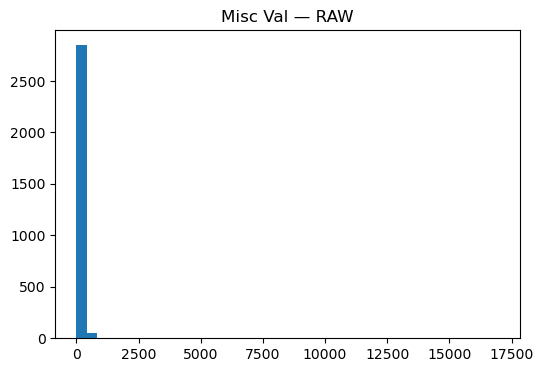

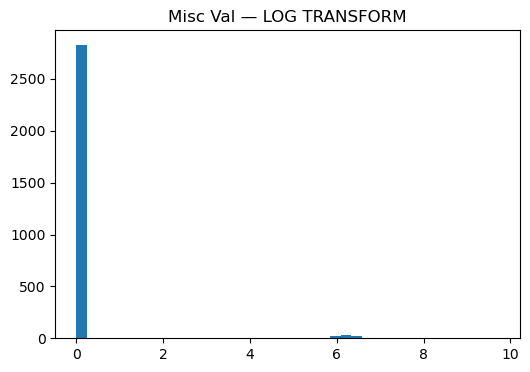

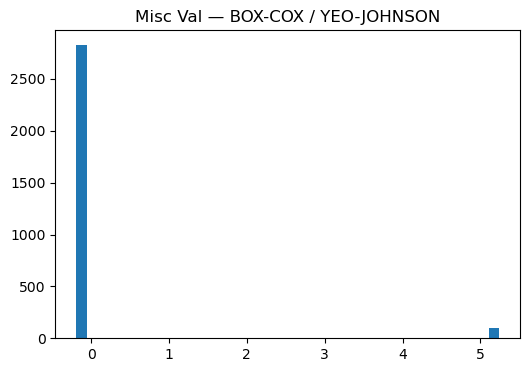

In [6]:
feature_to_plot = log_features[0]  # most skewed feature

plt.figure(figsize=(6,4))
plt.hist(df[feature_to_plot], bins=40)
plt.title(f"{feature_to_plot} — RAW")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df_log[feature_to_plot], bins=40)
plt.title(f"{feature_to_plot} — LOG TRANSFORM")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df_bc[feature_to_plot], bins=40)
plt.title(f"{feature_to_plot} — BOX-COX / YEO-JOHNSON")
plt.show()


## 7️⃣ Compare Skewness Reduction (Decision Table)

In [7]:
comparison = pd.DataFrame({
    "raw_skew": skewness[log_features],
    "log_skew": log_skewness,
    "boxcox_skew": bc_skewness
}).sort_values(by="raw_skew", ascending=False)

comparison.head(10)


,raw_skew,log_skew,boxcox_skew
Misc Val,21.988523,5.224855,5.048073
Pool Area,16.930469,15.026943,14.912715
Lot Area,12.814334,-0.498079,0.101362
Low Qual Fin SF,12.111957,8.574453,8.382353
3Ssn Porch,11.397956,8.842503,8.729374
Kitchen AbvGr,4.311616,3.528411,-2.069352
BsmtFin SF 2,4.138674,2.449067,2.341788
Enclosed Porch,4.012390,1.967279,1.889283
Screen Porch,3.955441,2.953239,2.922507
Bsmt Half Bath,3.940371,3.783299,3.715693


## 8️⃣ Save Both Versions (NO DECISION YET)

We do not choose yet.

We persist both pipelines for fair comparison.

In [8]:
df_log.to_csv("ames_housing_log_v1.csv", index=False)
df_bc.to_csv("ames_housing_boxcox_v1.csv", index=False)

print("Saved:")
print("→ ames_housing_log_v1.csv")
print("→ ames_housing_boxcox_v1.csv")


Saved:
→ ames_housing_log_v1.csv
→ ames_housing_boxcox_v1.csv
